In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import pystan
import arviz

import sys
sys.path.append("../")
from src.preprocess_data import (
    create_df,
)

from src.utils import print_results, get_class_probs, get_stan_model

In [4]:
df = create_df("../../data/games.csv")

train = df.loc[df["date"] < "2019-01-01"]
test = df.loc[df["date"] >= "2019-01-01"]

In [7]:
model_dir = Path("../../stan_models/")
model_name = "ordered_logistic_elo_diff_raw"

load_model = True

In [8]:
model = get_stan_model(model_dir, model_name, load_model)

In [9]:
stan_data = {
    "num_games": len(train),
    "p1_elo_diff_p2": train["p1_elo_diff_p2_scaled"].values,
    "player_1_white": train["p1_white"].values.astype(int),
    "y": train["p1_outcome"].values,
    
    # Predict on test set:
    "num_test_games": len(test),
    "p1_elo_diff_p2_test": test["p1_elo_diff_p2_scaled"].values,
    "p1_test_white": test["p1_white"].values.astype(int),
}

In [10]:
fit = model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [11]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [12]:
summary_df.head(10)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,e,3.032,0.208,2.647,3.422,0.004,0.003,3090.0,3048.0,3088.0,2883.0,1.0
1,w,0.730,0.096,0.547,0.905,0.002,0.001,2400.0,2393.0,2403.0,2434.0,1.0
2,c[0],-0.904,0.075,-1.045,-0.764,0.002,0.001,2345.0,2342.0,2348.0,2826.0,1.0
3,c[1],1.699,0.084,1.542,1.857,0.002,0.001,2777.0,2763.0,2778.0,2923.0,1.0
4,ypred[0],1.083,0.305,1.000,2.000,0.005,0.004,3630.0,3630.0,3534.0,3459.0,1.0
5,ypred[1],2.653,0.546,2.000,3.000,0.009,0.006,3981.0,3981.0,3984.0,4000.0,1.0
6,ypred[2],2.804,0.440,2.000,3.000,0.007,0.005,4006.0,4000.0,4002.0,3990.0,1.0
7,ypred[3],1.250,0.477,1.000,2.000,0.007,0.005,4083.0,4019.0,4101.0,3680.0,1.0
8,ypred[4],1.441,0.584,1.000,2.000,0.009,0.007,4021.0,4021.0,4017.0,3952.0,1.0
9,ypred[5],2.702,0.512,2.000,3.000,0.008,0.006,3860.0,3833.0,3850.0,3777.0,1.0


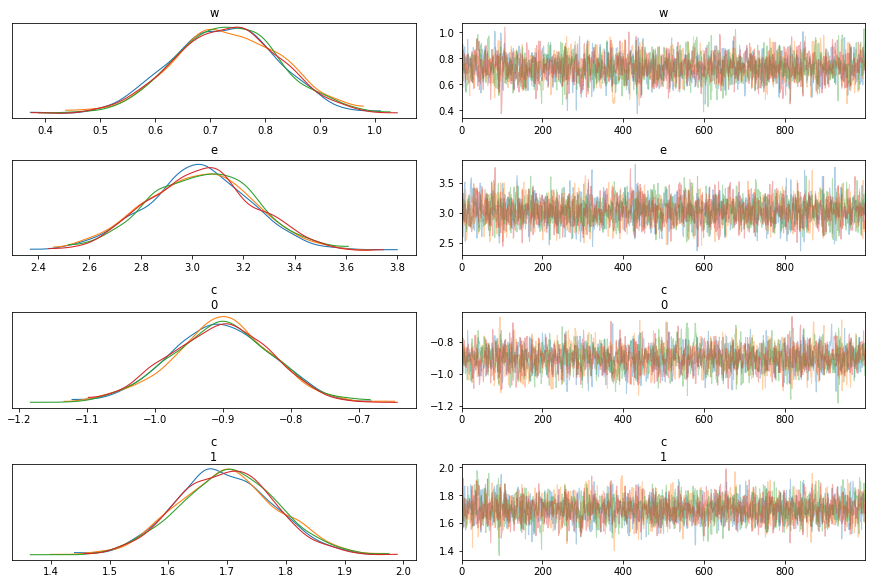

In [13]:
arviz.plot_trace(inference_data, var_names=["w", "e", "c"]);

In [14]:
train_cls_probs = get_class_probs(params, "ypred")
cls_pred = np.argmax(train_cls_probs, 1) + 1
print_results(train, cls_pred, "Train", dp=4)

Train - exact: 0.5507, out by one: 0.4428, out by two: 0.0065


In [15]:
test_cls_probs = get_class_probs(params, "ypred_test")
cls_pred_test = np.argmax(test_cls_probs, 1) + 1
print_results(test, cls_pred_test, "Test", dp=4)

Test - exact: 0.5497, out by one: 0.4411, out by two: 0.0092
